# Assignment #3
## Topic: Political Reviews - 
Name: **Hoo Yee Torng** </br>
Matrix: **P101447**

## 1.0 IMPORT LIBRARY
Import all the library needed and download the 

In [0]:
import pandas as pd
import nltk
import time
import numpy as np
import re
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## 2.0 Load Dataset files to be processed
download following files and upload to the workspace
- [politic_issues_positive_reviews.csv](https://drive.google.com/drive/folders/1SBji6xGIjRWvhm41MKIquDML_d-qsvW9?usp=sharing)
- [politic_issues_negative_reviews.csv](https://drive.google.com/drive/folders/1SBji6xGIjRWvhm41MKIquDML_d-qsvW9?usp=sharing) <br/>

Create a combined master set of data with class **0 as Negative** review and **1 as Positive**

In [0]:
# READ FROM NEGATIVE REVIEW AND ASSIGN 0 AS CLASS VALUE
negative_df = pd.read_csv('politic_issues_negative_reviews.csv')
negative_df["label"] = 0
print(negative_df.shape)

# READ FROM POSITIVE REVIEW AND ASSIGN 1 AS CLASS VALUE
positive_df = pd.read_csv('politic_issues_positive_reviews.csv')
positive_df["label"] = 1
print(positive_df.shape)

# APPEND BOTH DATAFRAME AS 1
raw_df = positive_df.append(negative_df) 

# RENAME COLUMN
raw_df = raw_df.rename(columns={"Google Translate": "review"})
print(raw_df.shape)

raw_df.index = range(100)
raw_df['review'].apply(lambda x: len(x.split(' '))).sum()


(54, 2)
(46, 2)
(100, 2)


3522

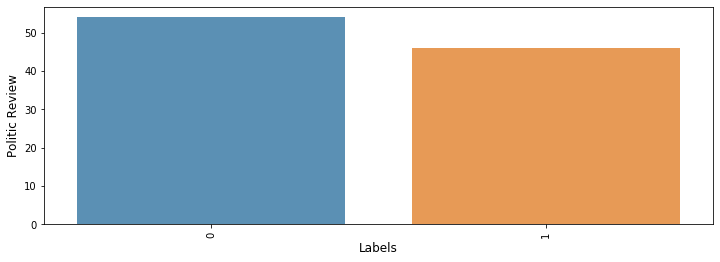

In [0]:
cnt_pro = raw_df['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Politic Review', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show();

## 3.0 PRE-PROCESSING

In [0]:
def extract_words(setence):
  text = re.sub("[^a-zA-Z]", " ", setence)
  return(text.lower())

def clean_word(sentence):
  text = re.sub(r'\|\|\|', r' ', sentence) 
  text = re.sub(r'http\S+', r'<URL>', text)
  text = text.replace('x', '')
  return text

def remove_stopword(sentence):
    new_line = []
    word_tokens = nltk.word_tokenize(sentence)
    for w in word_tokens:
      if w not in stop_words:
        new_line.append(w)
    
    return (" ".join(new_line) + " ").strip()

def get_adjective_word(setence):
  words = []
  pos_spacy = ['ADJ', 'ADV']
  pos_nltk = ['JJ','JJR', 'JJS','RB','RBS','RBR']
  
  ## CHECK BY SPACY FIRST
  spacy_words = nlp(u''+setence+'')
  for token in spacy_words:
    if token.pos_ in pos_spacy:
      words.append(token.text)

  ## CHECK BY NLTK
  nltk_words = nltk.word_tokenize(setence)
  for stc in nltk_words:
    nltk_token = nltk.pos_tag(nltk.word_tokenize(stc))
    if nltk_token[0][1] in pos_nltk and nltk_token[0][0] not in words:
      #print("NTLK : {}:{}".format(nltk_token[0][0], nltk_token[0][1]))
      words.append(nltk_token[0][0])
    
  return (" ".join(words) + " ").strip()

def text_processing(objdf):
  for index, row in objdf.iterrows():
    selected_review = row['review'].strip()
    #print("--")
    #print(selected_review)
    selected_review = extract_words(selected_review)
    selected_review = clean_word(selected_review)
    selected_review = remove_stopword(selected_review)
    #selected_review = get_adjective_word(selected_review)
    objdf.loc[index, "review"] = selected_review 
    #print(objdf.loc[index, "review"])
  return objdf

df = text_processing(raw_df)

In [0]:
def show_percentage(x):
  return "{0:.2f}%".format(round(x, 2) * 100)

def run_ML(feature_name, xtrain, ytrain, xtest, ytest):

  print("-----------------------------------------------------------------------------")
  print("- " + feature_name)
  print("-----------------------------------------------------------------------------")

  if feature_name == "Doc2Vec":
    clf_dict = {
      'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100),
      'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0),
      'GaussianNB': GaussianNB(),
      'ANN': MLPClassifier(solver='adam', hidden_layer_sizes=(10,5), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
      'SVN': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
      'LinearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
      'LogisticRegression': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
    }    
  else:
    clf_dict = {
      'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=100),
      'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0),
      'MultinomialNB': MultinomialNB(),
      'ANN': MLPClassifier(solver='adam', hidden_layer_sizes=(10,5), random_state=2, activation='relu', max_iter=5000, learning_rate='invscaling'),
      'SVN': svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=2000, decision_function_shape='ovr', random_state=2),
      'LinearSVC': LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=30000),
      'LogisticRegression': LogisticRegression(random_state=42, max_iter=8000, multi_class='auto', solver='saga'),
    }

  for name, clf in clf_dict.items():
    clf.fit(xtrain, ytrain) 
    pred = clf.predict(xtest)
    print("-- " + name)
    print('Testing accuracy: {}'.format(show_percentage(accuracy_score(ytest, pred))))
    print('Testing F1 score: {}'.format(show_percentage(f1_score(ytest, pred, average='macro'))))
    print('Testing Precision score: {}'.format(show_percentage(precision_score(ytest, pred, average='macro'))))
    print('Testing Recall score: {} \n'.format(show_percentage(recall_score(ytest, pred, average='macro'))))    

In [0]:
features = df['review'].values
classes = df['label'].values

sentences_train, sentences_test, yy_train, yy_test = train_test_split(features, classes, test_size=0.1, random_state=42, shuffle=True)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(sentences_train.shape[0]))
print('Number of rows in the test set: {}'.format(sentences_test.shape[0]))

Number of rows in the total set: 100
Number of rows in the training set: 90
Number of rows in the test set: 10


## 4.1 FEATURE - BOW

In [0]:
BOW = CountVectorizer()
BOW.fit(sentences_train)
XX_train = BOW.transform(sentences_train)
XX_test  = BOW.transform(sentences_test)
run_ML("BOW", XX_train, yy_train, XX_test, yy_test)

-----------------------------------------------------------------------------
- BOW
-----------------------------------------------------------------------------
-- GradientBoostingClassifier
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 

-- RandomForestClassifier
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- MultinomialNB
Testing accuracy: 60.00%
Testing F1 score: 58.00%
Testing Precision score: 75.00%
Testing Recall score: 67.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- ANN
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- SVN
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- LinearSVC
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- LogisticRegression
Testing accuracy: 60.00%
Testing F1 score: 58.00%
Testing Precision score: 75.00%
Testing Recall score: 67.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.2 FEATURE-TF - IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF = TfidfVectorizer()
TFIDF.fit_transform(sentences_train)
XXX_train = TFIDF.transform(sentences_train)
XXX_test  = TFIDF.transform(sentences_test)

run_ML("TF-IDF", XXX_train, yy_train, XXX_test, yy_test)

-----------------------------------------------------------------------------
- TF-IDF
-----------------------------------------------------------------------------
-- GradientBoostingClassifier
Testing accuracy: 60.00%
Testing F1 score: 58.00%
Testing Precision score: 75.00%
Testing Recall score: 67.00% 

-- RandomForestClassifier
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- MultinomialNB
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-- ANN
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- SVN
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- LinearSVC
Testing accuracy: 70.00%
Testing F1 score: 70.00%
Testing Precision score: 79.00%
Testing Recall score: 75.00% 

-- LogisticRegression
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.3 Feature - Doc2Vec

In [0]:
import multiprocessing
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
cores = multiprocessing.cpu_count()
from tqdm import tqdm
from sklearn import utils

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [0]:
# SPLIT TO 9:1
doc2vec_train, doc2vec_test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

# CONVERT TO DOC TO VEC FORMAT
train_tagged = doc2vec_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['review']), tags=[r.label]), axis=1)
test_tagged = doc2vec_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['review']), tags=[r.label]), axis=1)


# dm :: dm=1, 'distributed memory' (PV-DM), 0=BOW
# vector_size :: Dimensionality of the feature vectors
# negative ::  0 = no negative sampling is used.
# hs :: If 1, hierarchical softmax will be used for model training. If set to 0, and negative is non-zero, negative sampling will be used.
# min_count (int, optional) – Ignores all words with total frequency lower than this.
# sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).
# workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 90/90 [00:00<00:00, 143258.96it/s]


In [0]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=100)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 90/90 [00:00<00:00, 24592.01it/s]


CPU times: user 14.7 s, sys: 1.28 s, total: 15.9 s
Wall time: 16.7 s


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

run_ML("Doc2Vec", X_train, y_train, X_test, y_test)

-----------------------------------------------------------------------------
- Doc2Vec
-----------------------------------------------------------------------------
-- GradientBoostingClassifier
Testing accuracy: 40.00%
Testing F1 score: 38.00%
Testing Precision score: 44.00%
Testing Recall score: 46.00% 

-- RandomForestClassifier
Testing accuracy: 50.00%
Testing F1 score: 45.00%
Testing Precision score: 72.00%
Testing Recall score: 58.00% 

-- GaussianNB
Testing accuracy: 50.00%
Testing F1 score: 49.00%
Testing Precision score: 50.00%
Testing Recall score: 50.00% 

-- ANN
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- SVN
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- LinearSVC
Testing accuracy: 40.00%
Testing F1 score: 29.00%
Testing Precision score: 20.00%
Testing Recall score: 50.00% 

-- LogisticRegression
Testing accuracy: 40.00%
Testing F1 s

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Testing Precision score: 20.00%
Testing Recall score: 50.00% 



### REPORT :<br>

#### BOW

| Classifier | Accuracy | F1 | Precision | Recall | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| Gradient Boosting | 50.00% | 45.00% | 72.00% | 58.00% |
| Random Forest | 40.00% | 29.00% | 20.00% | 50.00% |
| Multinomial NB | 60.00% | 58.00% | 75.00% | 67.00% |
| ANN | 70.00% | 70.00% | 79.00% | 75.00% |
| SVN | 40.00% | 29.00% | 20.00% | 50.00% |
| Linear | 70.00% | 70.00% | 79.00% | 75.00% |
| Logistic Regression | 60.00% | 58.00% | 75.00% | 67.00% |

#### TF-IDF

| Classifier | Accuracy | F1 | Precision | Recall | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| Gradient Boosting | 50.00% | 49.00% | 55.00% | 54.00% |
| Random Forest | 40.00% | 29.00% | 20.00% | 50.00% |
| Multinomial NB | 50.00% | 45.00% | 72.00% | 58.00% |
| ANN | 70.00% | 70.00% | 79.00% | 75.00% |
| SVN | 40.00% | 29.00% | 20.00% | 50.00% |
| Linear | 70.00% | 70.00% | 79.00% | 75.00% |
| Logistic Regression | 50.00% | 45.00% | 72.00% | 58.00% |

#### DOC2VEC

| Classifier | Accuracy | F1 | Precision | Recall | 
| ------------- | ------------- | ------------- | ------------- | ------------- |
| Gradient Boosting | 40.00% | 38.00% | 44.00% | 46.00% |
| Random Forest | 50.00% | 45.00% | 72.00% | 58.00% |
| Gaussian NB | 50.00% | 49.00% | 50.00% | 50.00% |
| ANN | 40.00% | 29.00% | 20.00% | 50.00% |
| SVN | 40.00% | 29.00% | 20.00% | 50.00% |
| Linear | 40.00% | 29.00% | 20.00% | 50.00% |
| Logistic Regression | 40.00% | 29.00% | 20.00% | 50.00% |


**Answer**
* #1 - ANN with BOW and TD-IDF
* #2 - Linear with BOW and TD-IDF

